In [1]:
import matplotlib.pyplot as plt
import numpy as np
from abc import abstractmethod    
from itertools import cycle
from IPython.display import clear_output
import time
from tqdm import tqdm
from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [2]:
import abc
from scipy.spatial import KDTree
from scipy.spatial.distance import minkowski
class PathPlanner(abc.ABC):
    def __init__(self, start=None, enviornment=None, **kwargs):
        super().__init__()
        self.start = np.array(start)
        self.Env = enviornment
        
    
    @abc.abstractmethod
    def find_path(self):
        pass

    @abc.abstractmethod
    def is_goal(self, state):
        """Abstract Method for defining if a state is close to the goal state."""
        pass
    
    
class Graph():
    def __init__(self, *nodes):
        self.nodes = [tuple(node) for node in nodes]
        
        self.parent = dict()
        self.edge = dict()
        
    def create_graph(self, nodes, edge, parent):
        G = Graph(*nodes)
        G.parent = parent
        G.edge = edge
        return G
   
    def get_new_edge(self, parent, path, child):    
        child = tuple(child)
        parent = tuple(parent)
        parent_path_time = self.edge[(self.parent[parent], parent)].times[-1] if self.parent.get(parent, None) else 0
        return Plan(parent_path_time + path.times, path.positions, path.open_loop_inputs, dt=path.dt) 
        
    def add_node(self, parent, path, child):
        child = tuple(child)
        parent = tuple(parent)
        self.nodes.append(child)
        self.parent[child] = parent
        parent_path_time = self.edge[(self.parent[parent], parent)].times[-1] if self.parent.get(parent, None) else 0
        self.edge[(parent, child)] = Plan(parent_path_time + path.times, path.positions, path.open_loop_inputs, dt=path.dt) 
    
    def get_edge_paths(self):
        for pair in self.edge:
            yield self.edge[pair]
   
    

    def prune(self, start, policy):
        children = {}
        for k, v in self.parent.items():
            children.setdefault(v, set()).add(k)
        
            
        nodes = [tuple(start)]
        parent_d = dict()
        edge_d = dict()
        
        def prune_helper(current):
            parent = current
            for child in children.get(parent, []):
                if children.get(child, None) is None:
                    continue
                key = (parent, child)
                edge = self.edge[key]
                not_safe = policy(edge)
                if not_safe:
                    continue
                parent_d[child] = parent
                nodes.append(child)
                edge_d[key] = edge
                prune_helper(child)
        prune_helper(tuple(start))                
        return self.create_graph(nodes, edge_d, parent_d)
        
    def construct_path_to(self, c):
        c = tuple(c)
        return Plan.chain_paths(self.construct_path_to(self.parent[c]), self.edge[(self.parent[c], c)]) if self.parent.get(c, None) else None
            
        
class RRT(PathPlanner):
    """Class used for creating RRT paths."""
    def __init__(self, bot=[], goal=None, model=None, ellipsoid=None, iterations=1000, p=2, **kwargs):
        super(RRT, self).__init__(**kwargs)
        assert model is not None
        assert goal is not None
        self.goal = np.array(goal)
        self.model = model
        self.iterations = iterations
        if ellipsoid is None:
            self.ellipsoid = np.ones_like(goal)
        else:
            self.ellipsoid = np.array(ellipsoid)
        self.plan = None
        self.p = p
        self.bot = bot
        self.G = None
    
    def plan_is_unsafe(self, plan):
        if self.Env.plan_is_not_safe(plan, self.bot) and self.Env.plan_is_not_in_bounds(plan) and self.Env.obs_in_path(plan.positions[:, :2]):
            return True
        return False
    
    def prune_G(self):
        self.G.prune(self.start, self.plan_is_unsafe)
        self.G = self.G.prune(self.start, self.plan_is_unsafe)
        
    def nearest_node(self, node_list, static_node):
        dist_fn = lambda n: minkowski(n, static_node, p=self.p)
        node = min(node_list, key=dist_fn) 
        return dist_fn(node), node
            
    def find_path(self, time_prefix=1):
        if self.plan is not None:
            if self.plan_is_unsafe(self.plan):
                return self.plan
        if self.G is None:
            self.G = Graph(self.start)
        else:
            self.prune_G()
        print(len(self.G.nodes))

        kdTree = KDTree(np.vstack(self.G.nodes), copy_data=True)
        node_cache = [self.start]
        self.plan = None
        r_i = 1.5
        r_f = 0.5
        rate = 1/self.iterations
        for _ in range(self.iterations):
            if _ % 1000 == 0:
                print(f"iter {_}, G Nodes: {len(self.G.nodes)}")
            
            q_r = self.model.get_random_state()
            
            if self.Env.in_obs(q_r[:2]):
                continue
            
            dd, ii = kdTree.query(np.matrix(q_r), p=self.p, k=1)
            dist, node = self.nearest_node(node_cache, q_r)
            
            if dist < dd[0]:
                q_n = node
            else:
                q_n = kdTree.data[ii][0]

            path_nr = self.model.local_plan(q_n, q_r)
            path_nr_truncated = path_nr.get_time_prefix((1 - rate*_) * r_i + r_f)
            
            pos_nr_truncated = path_nr_truncated.positions[:, :2]
            
            if self.Env.obs_in_path(pos_nr_truncated):
                continue
                
            q_r_truncated = path_nr_truncated.end_position()
            
            if all(q_r_truncated == q_n):
                continue
                
            new_plan = self.G.get_new_edge(q_n, path_nr_truncated, q_r_truncated)

            if self.Env.plan_is_not_safe(new_plan, self.bot) and self.Env.plan_is_not_in_bounds(new_plan):
                continue
            
            self.G.add_node(q_n, path_nr_truncated, q_r_truncated)
            node_cache.append(q_r_truncated)
            
            if len(node_cache) > 250:
                kdTree = KDTree(np.vstack(self.G.nodes), copy_data=True)
                node_cache = [node_cache[-1]]
            
            if self.is_goal(q_r_truncated):
                path_r_truncated_to_goal = self.model.local_plan(q_r_truncated, self.goal)
                
                if self.Env.obs_in_path(path_r_truncated_to_goal):
                    continue
                
                self.G.add_node(q_r_truncated, path_r_truncated_to_goal, self.goal)
                self.plan = self.G.construct_path_to(self.goal)
                return self.plan
              
        dd, ii = kdTree.query(np.matrix(q_r), p=self.p, k=1)
        dist, node = self.nearest_node(node_cache, q_r)
                
        q_closest = node if dist < dd[0] else kdTree.data[ii][0] 
        self.plan = self.G.construct_path_to(q_closest)
        print("No Path Found")
        return None
    
    def is_goal(self, state):
        """returns a boolean describing if the input state is close to the goal state of the state space"""
        if np.all(np.abs(state - self.goal) < self.ellipsoid):
            return True
        return False

In [3]:
class StateSpace(abc.ABC):
    """State Space"""
    def __init__(self, dim=2, q_lb=[-10, -10], q_ub=[10, 10], dt=0.1, **kwargs):
        self.dim = dim
        self.q_lb = np.array(q_lb)
        self.q_ub = np.array(q_ub)
        self.dt = dt
    
    @abc.abstractmethod
    def get_random_state(self):
        """Abstract Method for generating a random state in the state space."""
        pass
    
    @staticmethod
    @abc.abstractmethod
    def distance(state_1, state_2) -> float:
        """Abstract Method for defining the distance between two states"""
        pass
    
    @abc.abstractmethod
    def local_plan(self, state_1, state_2):
        pass
        
class HolonomicStateSpace(StateSpace):
    """Holonomic State Space Model"""
    def __init__(self, velocity=3, **kwargs):
        super(HolonomicStateSpace, self).__init__(**kwargs)
        self.sec_per_meter = 1/velocity
       
    
    @staticmethod
    def distance(state_1, state_2) -> float:
        """Distance Metric"""
        return np.linalg.norm(state_2 - state_1)
    
    def get_random_state(self):
        """Generates a random state in the state space."""
        return np.random.uniform(self.q_lb, self.q_ub, size=(self.dim,))
    
    
    def local_plan(self, state_1, state_2):
        v = state_2 - state_1
        dist = np.linalg.norm(v)
        total_time = dist * self.sec_per_meter
        
        vel = v / total_time
        
        p = lambda t: state_1 + v*(t/total_time)
        
        times = np.arange(0, total_time, self.dt)
        
        states = p(times[:, np.newaxis])
        
        inputs = np.tile(vel, (states.shape[0], 1))
        plan = Plan(times, states, inputs, dt=self.dt)
        
        return plan

class HolonomicAccelStateSpace(StateSpace):
    """Holonomic State Space Model"""
    def __init__(self, accel=3, goal=None, edges=[], delta = 0., **kwargs):
        super(HolonomicAccelStateSpace, self).__init__(**kwargs)
        self.accel = accel
        self.goal = goal
        self.v_const = self.create_vel_constraint(edges, delta)
        
    def create_vel_constraint(self,edges, delta=0.5):
        def circ(x_0, y_0):
            def f(x, y):
                s = 2**0.5
                return s + (((x - x_0) ** 2 + (y - y_0) ** 2) ** 0.5) ** 0.5
            return f

        circle_constraints = [circ(x, y) for x, y in edges]

        def f(x, y):
            
            A = np.min(np.array([circle(x, y) for circle in circle_constraints]), axis = 0)
            B = np.full_like(np.array(x), 2*np.sqrt(delta))

            return np.where(A > B, A, B)
        return f
    
    @staticmethod
    def distance(state_1, state_2) -> float:
        """Distance Metric"""
        #Euclidian Distance
        return np.linalg.norm(state_2[:2] - state_1[:2]) + 0.5 * np.linalg.norm(state_2[2:] - state_1[2:]) ** 2
    
    def get_random_state(self):
        """Generates a random state in the state space."""
        
        p = np.random.uniform(self.q_lb[:2], self.q_ub[:2], size=(self.dim//2,))
        
        v = np.random.uniform((-1, -1), (1, 1), size=(self.dim//2,))
        v = v/np.linalg.norm(v)
        v = v * np.sqrt(self.accel) * self.v_const(p[0], p[1])
        d_vect_goal = p - self.goal[:2]
        distance_to_goal = np.linalg.norm(d_vect_goal)
        
        if distance_to_goal < self.accel / np.linalg.norm(self.q_ub[2:] - self.q_lb[2:]):
            v = d_vect_goal
        return np.hstack((p, v))
        
    
    
    def local_plan(self, state_1, state_2):
        
        x_0 = state_1[:2]
        v_0 = state_1[2:]
        sec_squared_per_meter = 1/self.accel
        
        displacement = state_2[:2] - state_1[:2]
        velocity = state_2[2:] - state_1[2:]
        
        vel_mag = np.linalg.norm(displacement)
        accel_mag = np.linalg.norm(velocity)
        
        total_time = accel_mag * sec_squared_per_meter
        
        accel = velocity / total_time
        
        p = lambda t: x_0 + v_0 * (t/total_time) + 0.5 * accel * (t/total_time) ** 2
        v = lambda t: v_0 + accel * t/total_time
        
        times = np.arange(0, total_time, self.dt)
        
        states = np.hstack((p(times[:, np.newaxis]), v(times[:, np.newaxis])))
        inputs = np.tile(accel, (states.shape[0], 1))
        plan = Plan(times, states, inputs, dt=self.dt)
        
        return plan

class Plan(object):
    def __init__(self, times, target_positions, open_loop_inputs, dt=0.01):
        self.dt = dt
        self.times = times
        self.positions = target_positions
        self.open_loop_inputs = open_loop_inputs

    def __iter__(self):
        # I have to do this in an ugly way because python2 sucks and
        # I hate it.
        for t, p, c in zip(self.times, self.positions, self.open_loop_inputs):
            yield t, p, c

    def __len__(self):
        return len(self.times)

    def get(self, t):
        """Returns the desired position and open loop input at time t.
        """
        index = int(np.sum(self.times <= t))
        index = index - 1 if index else 0
        return self.positions[index], self.open_loop_inputs[index]

    def end_position(self):
        return self.positions[-1]

    def start_position(self):
        return self.positions[0]

    def get_time_prefix(self, until_time):
        """Returns a new plan that is a prefix of this plan up until the
        time until_time.
        """
        times = self.times[self.times <= until_time]
        positions = self.positions[self.times <= until_time]
        open_loop_inputs = self.open_loop_inputs[self.times <= until_time]
        return Plan(times, positions, open_loop_inputs, self.dt)
    
    def get_time_suffix(self, until_time):
        """Returns a new plan that is a prefix of this plan up until the
        time until_time.
        """
        times = self.times[self.times >= until_time]
        positions = self.positions[self.times >= until_time]
        open_loop_inputs = self.open_loop_inputs[self.times >= until_time]
        return Plan(times, positions, open_loop_inputs, self.dt)

    @classmethod
    def chain_paths(self, *paths):
        """Chain together any number of plans into a single plan.
        """
        def chain_two_paths(path1, path2):
            """Chains together two plans to create a single plan. Requires
            that path1 ends at the same configuration that path2 begins at.
            Also requires that both paths have the same discretization time
            step dt.
            """
            if not path1 and not path2:
                return None
            elif not path1:
                return path2
            elif not path2:
                return path1
            assert path1.dt == path2.dt, "Cannot append paths with different time deltas."
            # assert np.allclose(path1.end_position(), path2.start_position()), "Cannot append paths with inconsistent start and end positions."
            times = np.concatenate((path1.times, path2.times[1:]), axis=0)
            positions = np.concatenate((path1.positions, path2.positions[1:]), axis=0)
            open_loop_inputs = np.concatenate((path1.open_loop_inputs, path2.open_loop_inputs[1:]), axis=0)
            dt = path1.dt
            return Plan(times, positions, open_loop_inputs, dt=dt)
        chained_path = None
        for path in paths:
            chained_path = chain_two_paths(chained_path, path)
        return chained_path
    
    def __repr__(self):
        return str(self.positions)

        

In [4]:
import networkx

In [5]:
class Obstacle(object):
    """Class used to defines the structure of obstacles"""
    def __init__(self):
        super.__init__()
    
    @abstractmethod
    def is_point_inside(self, point):
        pass
    
    @abstractmethod
    def is_trajectory_intersected(self, *argv):
        pass
    
    @abstractmethod
    def plot(self, plt):
        pass

class RectangleObstacle(Obstacle):
    """Class that creates rectangle shaped objects"""
    def __init__(self, bottom_corner, top_corner):        
        self.min_x = bottom_corner[0]
        self.min_y = bottom_corner[1]
        self.max_x = top_corner[0]
        self.max_y = top_corner[1]
        
        
    def is_point_inside(self, point):
        pt_x, pt_y = point[0], point[1]
        return self.max_x >= pt_x and self.min_x <= pt_x and self.max_y >= pt_y and self.min_y <= pt_y
    
    def is_trajectory_intersected(self, trajectory):
        """Method uses disrete collision detection. Will expand to continous detection if needed -- however, we will probably just increase sample rate as needed instead."""
        return any([self.is_point_inside(point) for point in trajectory])
    
    def plot(self, plt, **kwargs):
        rectangle = plt.Rectangle((self.min_x,self.min_y), self.max_x - self.min_x,self.max_y-self.min_y, **kwargs)
        plt.gca().add_patch(rectangle)
    
    def delta_object(self, delta):
        return RectangleObstacle((self.min_x - delta, self.min_y - delta), (self.max_x + delta, self.max_y + delta))
    
    def get_obstacle_points(self):
        obs_pos = np.array([self.min_x, self.min_y, self.max_x, self.max_y])
        return obs_pos
        
    
class Environment(object):
    """Environment For simulation"""
    
    def __init__(self, dbots=[], obstacles=[], lb=(-10, -10), ub=(10, 10), **kwargs):
        self.robots = dbots
        self.obstacles = obstacles
        self.lb = lb
        self.ub = ub
            
    def update_dbot(self, dbot):
        self.robots = dbot
        
    def add_dbot(self, *dbot):
        self.robots.extend(dbot)
    
    def add_obstacle(self, obstacle):
        self.obstacles.append(obstacle)
    
    def in_obs(self, pos) -> bool:
        return any([obs.is_point_inside(pos) for obs in self.obstacles])
    
    def obs_in_path(self, path) -> bool:
        return any([obs.is_trajectory_intersected(path) for obs in self.obstacles])
    
    def plan_is_not_safe(self, plan, *bots):
        for t, p, c in plan:
            for bot in self.robots:
                if bot.plan is None or bot in bots:
                    continue
                pos = bot.get_position(t)[:2]
                if np.linalg.norm(p[:2] - pos) < 1.:
#                     print(f"{p[:2]}{pos}{bot}{bots}")
                    return True
        return False

    def plan_is_not_in_bounds(self, plan):
        for t, p, c in plan:
            x, y = p[0], p[1]
            if x > ub[0] or y > ub[1] or x < lb[0] or y < lb[1]:
                return True
        return False
    
    def get_env_obstacles(self):
        env_obs_list = []
        for obs in self.obstacles:
            env_obs_list.append(obs.get_obstacle_points())
        return env_obs_list
        
def get_obs_edges(obs_list):
    l = []
    for obs in obs_list:
        min_x, min_y, max_x, max_y = obs.min_x, obs.min_y, obs.max_x, obs.max_y
        l.extend([(min_x, min_y), (min_x, max_y), (max_x, min_y), (max_x, max_y)])
    return l
    
    
### world frame
class Frame(object):
    """Class for defining the frame in which obstacles and robots live."""
    
    degree = 2
    time = 0
    dbots = []
    obstacles = []
    
    def __init__(self, dbots=[], obstacles=[], delta_obs=[], lb=[0, 0], ub=[10, 10], **kwargs):
        self.__dict__.update(kwargs)
        self.dbots = dbots
        self.obstacles = obstacles
        self.delta_obs = delta_obs
        self.lb = lb
        self.ub = ub
        
    def add_dbot(self, dbot):
        assert type(dbot) == Dbot, "dbot must be a Dbot dawg."
        self.robots.extend(dbot)
    
    def add_obstacle(self, obstacle):
        assert type(obstacle) == RectangleObstacle, "obstacle must be an Obstacle dawg."
        self.obstacles.append(obstacle)
        
    def show_frame(self):

        fig, ax = plt.subplots(figsize=(12, 6))
        
        cycol = cycle("bgrcmykw")
        for dbot in self.dbots:
            pos = dbot.get_position(self.time)
            goal = dbot.get_goal()
            col = next(cycol)
            ax.plot(pos[0], pos[1], color=col, marker='o', linestyle='dashed', linewidth=2, markersize=12)
            ax.plot(goal[0], goal[1], color=col, marker='x', linestyle='dashed', linewidth=2, markersize=12)
        
        for obstacle in self.obstacles:
            obstacle.plot(plt, fc='black',ec="red")
        if self.delta_obs:
            for obstacle in self.delta_obs:
                obstacle.plot(plt, linestyle='--', fill=False, ec="orange")
            
        ax.set_xlim(self.lb[0], self.ub[0])
        ax.set_ylim(self.lb[1], self.ub[1])
        plt.show()
    
    def show_frame_with_vel(self,delta=0.5):

        edges = get_obs_edges(self.delta_obs)
        def circ(x_0, y_0):
            def f(x, y):
                s = 2**0.5
                return s + (((x - x_0) ** 2 + (y - y_0) ** 2) ** 0.5) ** 0.5
            return f

        circle_constraints = [circ(x, y) for x, y in edges]

        def f(x, y):
            
            A = np.min(np.array([circle(x, y) for circle in circle_constraints]), axis = 0)
            B = np.full_like(np.array(x), 2*np.sqrt(delta))

            return np.where(A > B, A, B)

        x = np.linspace(lb[0], ub[0], 2560)
        y = np.linspace(lb[1], ub[1], 2560)
        X, Y = np.meshgrid(x, y)
        Z = f(X, Y)
        
        fig = plt.figure()
        plt.rcParams["figure.figsize"] = (21,8.5)
        
        ax1 = plt.subplot(121)
        
        ax1.contourf(X, Y, Z, 8, alpha=0.9, cmap=plt.cm.coolwarm)
        C = ax1.contour(X, Y, Z, 8, colors='black')
        ax1.clabel(C, inline=1, fontsize=10)
        plt.xticks(())
        plt.yticks(())
        
        cycol = cycle("bgrcmykw")
        for dbot in self.dbots:
            pos = dbot.get_position(self.time)
            goal = dbot.get_goal()
            col = next(cycol)
            ax1.plot(pos[0], pos[1], color=col, marker='o', linestyle='dashed', linewidth=2, markersize=12)
            ax1.plot(goal[0], goal[1], color=col, marker='x', linestyle='dashed', linewidth=2, markersize=12)
            p = dbot.get_all_positions()
            ax1.plot(p[:,0], p[:,1], color=col)
         
        for obstacle in self.obstacles:
            obstacle.plot(plt, fc='black',ec="red")
        if self.delta_obs:
            for obstacle in self.delta_obs:
                obstacle.plot(plt, linestyle='--', fill=False, ec="yellow")
        
        ax1.set_xlim(self.lb[0], self.ub[0])
        ax1.set_ylim(self.lb[1], self.ub[1])
        
        ax2 = plt.subplot(122, projection="3d")

        # Plot the surface.
        surf = ax2.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                               linewidth=0, antialiased=False)

        # Customize the z axis.
        ax2.set_zlim(-1.01, 10.01)
        ax2.zaxis.set_major_locator(LinearLocator(10))
        # A StrMethodFormatter is used automatically
        ax2.zaxis.set_major_formatter('{x:.02f}')

        # Add a color bar which maps values to colors.
        fig.colorbar(surf, ax=ax2, shrink=0.5, aspect=5)
        
        plt.savefig("test.png")
        plt.show()



In [6]:
class dbot(object):
    """Class for defining dot represented robots"""
    def __init__(self, goal):
        self.goal = goal
        
    def get_goal(self):
        return self.goal
    
    def get_position(self, t):
        pass
    
    def get_all_positions(self):
        pass
    
import uuid     
class RRTBot(dbot):
    def __init__(self, model, start=(), goal=(), run=True, env=None, **kwargs):
        super().__init__(goal)
        kwargs["goal"] = goal
        
        self.Env = None
        if env is None:
            self.Env = Environment(dbot = [self], **kwargs)
        else:
            self.Env = env
            self.Env.add_dbot(self)
        self.model = model(edges =get_obs_edges(kwargs.get("obstacles", [])) , **kwargs)
        
        
        self.rrt = RRT(bot=self, start=start, model=self.model, enviornment=self.Env, **kwargs)
        self.uuid = uuid.uuid4()
        self.plan = None
            
    
    def find_plan(self):
        self.rrt.find_path()
        return self.rrt.plan
    
    def update_plan(self, plan):
        self.plan = plan
        self.total_time = self.plan.times[-1]
        self.dt = self.plan.dt
        
    def update_constraints(self, dbot=[]):
        self.Env.update_dbot(dbot)
        
    def set_new_plan(self):
        self.update_plan(self.find_plan())
    
    def get_position(self, t):
        return self.plan.get(t)[0]
    
    def get_all_positions(self):
        return self.plan.positions
    
    def get_obstacles(self):
        return self.Env.get_env_obstacles()
    
    def __eq__(self, dbot):
        return self.uuid == dbot.uuid
    
    def __repr__(self):
        return str(self.uuid)
    
    def __str__(self):
        return str(self.uuid)
    
class DMA_RRT(object):
    def __init__(self, *rrt_bots):
        
        self.dma_rrt_bots = [bot for bot in rrt_bots]
        
        #initialize with p_0
        for i, bot in enumerate(self.dma_rrt_bots):
            bot.update_constraints(self.dma_rrt_bots)
            bot.idx = i
            bot.have_token = False
            bot.set_new_plan()
            bot.bid = 0
              
        self.iterations = 5
        self.waypoints = [None for bot in self.dma_rrt_bots]
        
        have_token = np.random.randint(len(self.dma_rrt_bots))
        self.dma_rrt_bots[have_token].have_token = True
        
        print("DEBUG: rrt_bots after init: ", self.dma_rrt_bots)
        for bot in self.dma_rrt_bots:
            print(bot.idx, bot.have_token, bot.bid)
    
    def cost(self, plan):
        return plan.times[-1] / len(plan.times) * plan.dt
    
    def find_plans(self):
        for k in range(self.iterations):
            print(f"DMA Iter: {k}")
            min_bid, min_idx = np.inf, None
            for bot in self.dma_rrt_bots:
                pk_star = bot.find_plan()
                if bot.have_token:
                    bot.update_plan(pk_star)
                    bot.bid = 0
                    bot.have_token = False
                else:
                    # bot.p = bot.p
                    bot.bid = (self.cost(bot.plan) - self.cost(pk_star))
                    # Broadcast Bid
                    if min_bid > bot.bid:
                        min_bot = bot
                        min_bid = bot.bid
            #winner            
            min_bot.have_token = True

import networkx as nx          
class DMA_LOS_RRT(object):
    def __init__(self, *rrt_bots):

        self.dma_los_rrt_bots = [bot_candidate for bot_candidate in rrt_bots]

        # initialize with p_0
        for i, bot in enumerate(self.dma_los_rrt_bots):
            bot.update_constraints(self.dma_los_rrt_bots)
            bot.idx = i
            bot.have_token = False
            bot.set_new_plan()
            bot.bid = 0

        self.iterations = 5
        self.waypoints = [None for bot_candidate in self.dma_los_rrt_bots]

        have_token = np.random.randint(len(self.dma_los_rrt_bots))
        self.dma_los_rrt_bots[have_token].have_token = True

        print("DEBUG: los_rrt_bots after init: ", self.dma_los_rrt_bots)
        for bot in self.dma_los_rrt_bots:
            print(bot.idx, bot.have_token, bot.bid)

    def sin_product(self, vec1, vec2):
        return vec1[0] * vec2[1] - vec2[0] * vec1[1]

    def segment_intersection(self, pos1, pos2, pos3, pos4):
        ZERO = 1e-9

        vec1 = pos3 - pos1
        vec2 = pos4 - pos1
        vec3 = pos3 - pos2
        vec4 = pos4 - pos2

        inv_vec1 = pos1 - pos3
        inv_vec2 = pos1 - pos4
        inv_vec3 = pos2 - pos3
        inv_vec4 = pos2 - pos4

        vec_product1 = self.sin_product(vec1, vec2)
        vec_product2 = self.sin_product(vec3, vec4)
        vec_product3 = self.sin_product(inv_vec1, inv_vec3)
        vec_product4 = self.sin_product(inv_vec2, inv_vec4)

        if vec_product1 * vec_product2 <= ZERO and vec_product3 * vec_product4 <= ZERO:
            return True

    def judgement_LOS(self, position1, position2, rec1, rec2):
        if min(position1[0], position2[0]) >= rec1[0] and max(position1[0],position2[0]) <= rec2[0] and min(position1[1], position2[1]) >= rec1[1] and max(position1[1], position2[1]) <= rec2[1]:
                return False
        else:
            if self.segment_intersection(position1, position2, rec1, rec2):
                return False
            else:
                return True
    
    def get_rec(self):
        rec_list = self.dma_los_rrt_bots[0].get_obstacles()
        print(rec_list)
#         self.dma_los_rrt_bots[j].
#         rec_list = []
#         rec1 = np.array([3, 3, 10, 10])
#         rec_list.append(rec1)
#         rec2 = np.array([16, 16, 17, 17])
#         rec_list.append(rec1)
#         rec3 = np.array([10, 15, 12, 17])
#         rec_list.append(rec1)
        return rec_list

    def cost(self, plan):
        return plan.times[-1] / len(plan.times) * plan.dt

    def find_plans(self):
        obstacles_list = self.get_rec()
        
        for k in range(self.iterations):
            G_new = nx.Graph()
            for node in range(len(self.dma_los_rrt_bots)):
                node = str(node)
                G_new.add_node(node)
            print(f"DMA_LOS Iter: {k}")
            min_bid, min_idx = np.inf, None
            for i in range(len(self.dma_los_rrt_bots) - 1):
                bot_candidate = self.dma_los_rrt_bots[i]
                pos_bot1 = bot_candidate.get_position(k) 
                for j in range(self.dma_los_rrt_bots.index(bot_candidate) + 1, len(self.dma_los_rrt_bots)):
                    pos_botk = self.dma_los_rrt_bots[j].get_position(k)
                    flag = 0
                    for rec in obstacles_list:
                        rec1 = np.array([rec[0], rec[1]])
                        rec2 = np.array([rec[2], rec[3]])
                        if self.judgement_LOS(pos_bot1, pos_botk, rec1, rec2) == False:
                            flag = 1
                            #print(self.judgement_LOS(pos_bot1, pos_botk, rec1, rec2))
                        else:
                            continue
                    if flag == 0:
#                         print("!!!!")
                        G_new.add_edge(str(i), str(j))
            G_new_connect = nx.connected_components(G_new)
            for subgraph_los in G_new_connect:
                print("==subgraph==",subgraph_los)
                for kk in subgraph_los:
                    inx_bot = int(kk)
                    bot = self.dma_los_rrt_bots[inx_bot]
                    pk_star = bot.find_plan()
                    position_now = bot.get_position(k)
                    print("====pos=====:",kk, position_now)
                    if bot.have_token:
                        bot.update_plan(pk_star)
                        bot.bid = 0
                        bot.have_token = False
                    else:
                        # bot.p = bot.p
                        bot.bid = (self.cost(bot.plan) - self.cost(pk_star))
                        # Broadcast Bid
                        if min_bid > bot.bid:
                            min_bot = bot
                            min_bid = bot.bid
                # winner
                min_bot.have_token = True

In [7]:
rect_list = [RectangleObstacle((3, 3), (10, 10)), RectangleObstacle((16, 16), (17, 17)), RectangleObstacle((10, 15), (12, 17))] 
delta = 0.5
expanded_list = [obs.delta_object(delta) for obs in rect_list]
lb = (0, 0)
ub = (100, 100)

In [44]:

kwargs = {'accel' : 3,
      'run' : False,
      'dim' : 4, 
      'lb' : (0, 0),
      'ub' : (20, 20),
      'q_lb' : (0, 0, -5, -5), 
      'q_ub' : (20, 20, 5, 5), 
      'dt' : 0.1, 
      'delta': 0.5,
      'obstacles' : expanded_list, 
      'ellipsoid' : (0.5, 0.5, 0.3, 0.3), 
      'iterations' : 10000}

1
iter 0, G Nodes: 1
1
iter 0, G Nodes: 1
iter 1000, G Nodes: 845
1
iter 0, G Nodes: 1
DEBUG: los_rrt_bots after init:  [60e93262-f062-4cd5-9f0b-bfb40716cba9, a213af8d-30c7-46ad-81df-c83dc41a7486, 92566781-7d45-4a2b-b714-50428884790b]
0 True 0
1 False 0
2 False 0
[array([ 2.5,  2.5, 10.5, 10.5]), array([19.5, 65.5, 25.5, 77.5]), array([73.5, 45.5, 79.5, 67.5]), array([15.5, 15.5, 17.5, 17.5]), array([ 9.5, 14.5, 12.5, 17.5]), array([89.5, 94.5, 90.5, 97.5]), array([79.5, 25.5, 95.5, 43.5]), array([41.5, 40.5, 45.5, 47.5]), array([92.5, 15.5, 96.5, 19.5]), array([39.5, 14.5, 52.5, 37.5]), array([59.5, 79.5, 76.5, 95.5])]
DMA_LOS Iter: 0
==subgraph== {'0', '2', '1'}
33
iter 0, G Nodes: 33
iter 1000, G Nodes: 870
====pos=====: 0 [91.  1.]
159
iter 0, G Nodes: 159
====pos=====: 2 [15. 95.]
476
iter 0, G Nodes: 476
====pos=====: 1 [18. 18.]
DMA_LOS Iter: 1
==subgraph== {'0', '2', '1'}
818
iter 0, G Nodes: 818
====pos=====: 0 [88.80672356  3.04683621]
238
iter 0, G Nodes: 238
====pos=====: 2

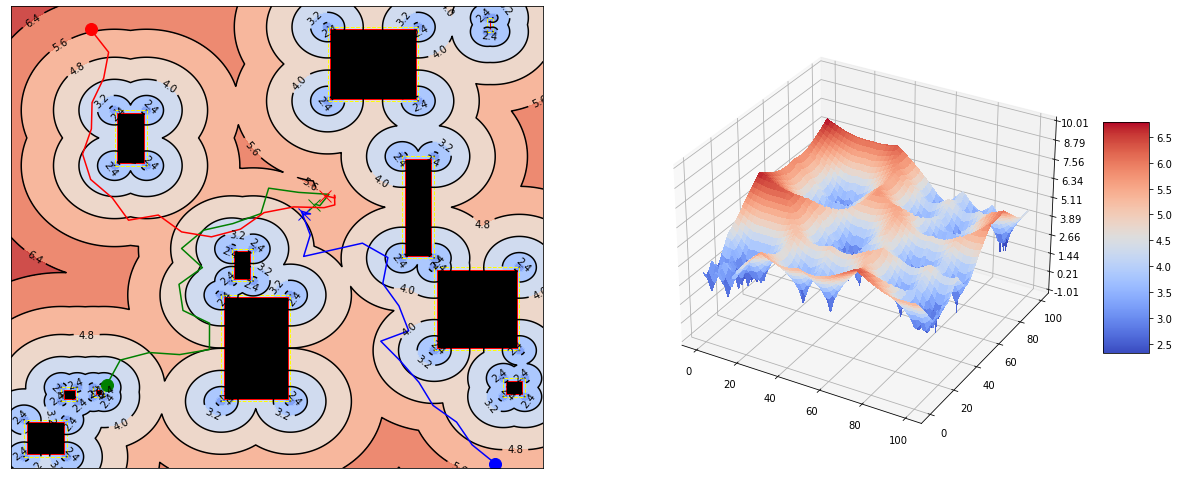

In [8]:
rrtdb = RRTBot(HolonomicStateSpace, start = (1., 1.), goal = (19., 19.), **kwargs)
rrtdb2 = RRTBot(HolonomicStateSpace, start = (18., 18.), goal = (2., 2.), **kwargs)
rrtdb3 = RRTBot(HolonomicStateSpace, start = (15., 5.), goal = (5., 14.5), **kwargs)
dbots = [rrtdb, rrtdb2, rrtdb3]

dma = DMA_LOS_RRT(*dbots)
dma.find_plans()

Frame(dbots=[rrtdb, rrtdb2, rrtdb3], obstacles=rect_list, delta_obs = expanded_list, time = 0, lb=lb, ub=ub).show_frame_with_vel()

# for t in tqdm(np.arange(0, rrtdb.total_time + rrtdb.dt, rrtdb.dt)):
#     time.sleep(rrtdb.dt)
#     clear_output(wait=True)
#     print(f"Bot's velocity: {rrtdb.plan.get(t)} time: {rrtdb.plan.times[int(t//rrtdb.dt)]}")
#     Frame(dbots=[rrtdb, rrtdb2, rrtdb3], obstacles=rect_list, delta_obs = expanded_list, time = t, lb=lb, ub=ub).show_frame()

1
iter 0, G Nodes: 1
1
iter 0, G Nodes: 1
1
iter 0, G Nodes: 1
DEBUG: los_rrt_bots after init:  [79ac2bce-827e-460e-b413-6e1af84693f5, a5420975-3aa0-4bd1-94e7-1c1b76d7464b, d8b3c853-ff25-4861-b0ea-db794a37fb23]
0 True 0
1 False 0
2 False 0
[array([ 2.5,  2.5, 10.5, 10.5]), array([15.5, 15.5, 17.5, 17.5]), array([ 9.5, 14.5, 12.5, 17.5])]
DMA_LOS Iter: 0
==subgraph== {'2', '0', '1'}
229
iter 0, G Nodes: 229
====pos=====: 2 [15.  5.]
342
iter 0, G Nodes: 342
====pos=====: 0 [1. 1.]
26
iter 0, G Nodes: 26
iter 1000, G Nodes: 789
====pos=====: 1 [18. 18.]
DMA_LOS Iter: 1
==subgraph== {'2', '0', '1'}
323
iter 0, G Nodes: 323
iter 1000, G Nodes: 992
iter 2000, G Nodes: 1557
iter 3000, G Nodes: 1993
====pos=====: 2 [15.2796035   7.98694189]
233
iter 0, G Nodes: 233
====pos=====: 0 [3.99106178 1.23140749]
671
iter 0, G Nodes: 671
iter 1000, G Nodes: 1302
====pos=====: 1 [15.1483549  18.93172969]
DMA_LOS Iter: 2
==subgraph== {'2', '0'}
1241
iter 0, G Nodes: 1241
iter 1000, G Nodes: 1740
====pos

KeyboardInterrupt: 

In [30]:
rect_list = [RectangleObstacle((2., 15.), (18., 18.)), RectangleObstacle((4., 2.), (17., 6.)), RectangleObstacle((0., 9.), (20., 12.))] 

expanded_list = [obs.delta_object(0.5) for obs in rect_list]

kwargs = {'accel' : 3,
          'run' : False,
          'dim' : 4, 
          'lb' : (0, 0),
          'ub' : (20, 20),
          'q_lb' : (0, 0, -5, -5), 
          'q_ub' : (20, 20, 5, 5), 
          'dt' : 0.1, 
          'delta': 0.5,
          'obstacles' : expanded_list, 
          'ellipsoid' : (0.5, 0.5, 0.3, 0.3), 
          'iterations' : 10000}

rrtdb = RRTBot(HolonomicAccelStateSpace, start=(8., 1., 0., 0.), goal=(14., 14., 0., 0.), **kwargs)
rrtdb2 = RRTBot(HolonomicAccelStateSpace, start=(13.5, 13.5, 0., 0.), goal=(9., 0.5, 0., 0.), **kwargs)
rrtdb3 = RRTBot(HolonomicAccelStateSpace, start=(5., 10., 0., 0.), goal=(10., 7.5, 0., 0.), **kwargs)

dma = DMA_RRT(rrtdb, rrtdb2, rrtdb3)
dma.find_plans()

1
iter 0, G Nodes: 1
iter 1000, G Nodes: 303
iter 2000, G Nodes: 569
iter 3000, G Nodes: 831
iter 4000, G Nodes: 1084
iter 5000, G Nodes: 1296
iter 6000, G Nodes: 1511
iter 7000, G Nodes: 1736
iter 8000, G Nodes: 1956
iter 9000, G Nodes: 2193
No Path Found
1
iter 0, G Nodes: 1
iter 1000, G Nodes: 109
iter 2000, G Nodes: 326
iter 3000, G Nodes: 547
iter 4000, G Nodes: 763
iter 5000, G Nodes: 1000
iter 6000, G Nodes: 1246
iter 7000, G Nodes: 1481


KeyboardInterrupt: 

Bot's velocity: (array([0.54815375, 3.41784159, 1.17874244, 1.00431312]), array([2.28353919, 1.94562298])) time: 2.4000000000000004


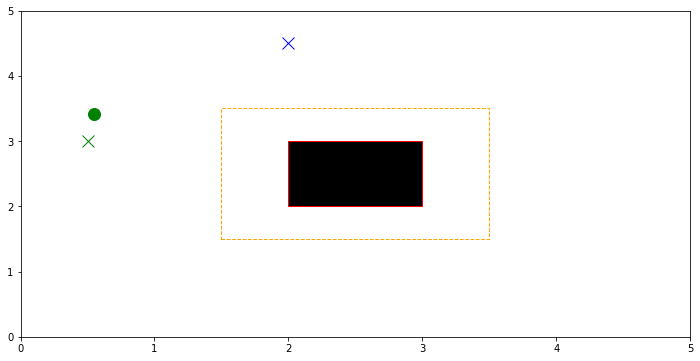

100%|███████████████████████████████████████████| 26/26 [00:05<00:00,  4.59it/s]


In [15]:
for t in tqdm(np.arange(0, rrtdb2.total_time + rrtdb2.dt, rrtdb2.dt)):
    time.sleep(rrtdb2.dt)
    clear_output(wait=True)
    print(f"Bot's velocity: {rrtdb2.plan.get(t)} time: {rrtdb2.plan.times[int(t//rrtdb2.dt)]}")
    Frame(dbots=[rrtdb, rrtdb2], obstacles=rect_list, delta_obs = expanded_list, time = t, lb=lb, ub=ub).show_frame()
    

In [ ]:
Frame(dbots=[rrtdb, rrtdb2, rrtdb3], obstacles=rect_list, delta_obs = expanded_list, time = 0, lb=lb, ub=ub).show_frame_with_vel()

In [13]:
rect_list = [RectangleObstacle((2., 2.), (3., 3.))] 
expanded_list = [obs.delta_object(0.5) for obs in rect_list]
lb = (0, 0)
ub = (5, 5)
kwargs = {'accel' : 3,
          'run' : False,
          'dim' : 4, 
          'lb' : lb,
          'ub' : ub,
          'q_lb' : (0, 0, -1, -1), 
          'q_ub' : (5, 5, 1, 1), 
          'dt' : 0.1, 
          'delta': 0.5,
          'p' : 200,
          'obstacles' : expanded_list, 
          'ellipsoid' : (0.5, 0.5, 1.0, 1.0), 
          'iterations' : 5000}

rrtdb = RRTBot(HolonomicAccelStateSpace, start=(0.5, 2.5, 0., 0.), goal=(2., 4.5, 0., 0.), **kwargs)
rrtdb2 = RRTBot(HolonomicAccelStateSpace, start=(2.5, 4.5, 0., 0.), goal=(0.5, 3., 0., 0.), **kwargs)

dma = DMA_RRT(rrtdb, rrtdb2)
dma.find_plans()

1
iter 0, G Nodes: 1
iter 1000, G Nodes: 660
1
iter 0, G Nodes: 1
DEBUG: rrt_bots after init:  [3bd4d036-195f-4a94-b23f-93ebe401ace4, 2c7c0f4a-4c54-4ec7-b9b3-e7e0225dab79]
0 False 0
1 True 0
DMA Iter: 0
186
iter 0, G Nodes: 186
5
iter 0, G Nodes: 5
DMA Iter: 1
64
iter 0, G Nodes: 64
7
iter 0, G Nodes: 7
DMA Iter: 2
41
iter 0, G Nodes: 41
7
iter 0, G Nodes: 7
DMA Iter: 3
63
iter 0, G Nodes: 63
13
iter 0, G Nodes: 13
DMA Iter: 4
33
iter 0, G Nodes: 33
38
iter 0, G Nodes: 38


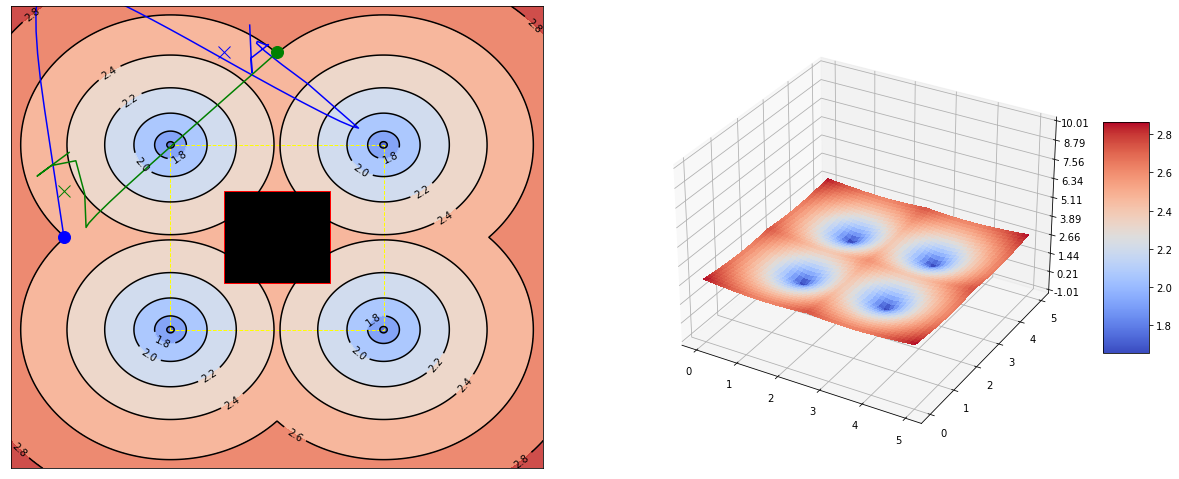

In [14]:
Frame(dbots=[rrtdb, rrtdb2], obstacles=rect_list, delta_obs = expanded_list, time = 0, lb=lb, ub=ub).show_frame_with_vel()



In [ ]:
rect_list = [RectangleObstacle((2, 2), (4.5, 8.5)), RectangleObstacle((5, 6), (7, 8)), RectangleObstacle((6, 3), (9, 5))] 
expanded_list = [obs.delta_object(0.5) for obs in rect_list]
lb = (-10, -10)
ub = (10, 10)

kwargs = {'velocity' : 3,
          'dim' : 2, 
          'lb' : lb, 
          'ub' : ub,
          'q_lb' : lb,
          'q_ub' : ub,
          'dt' : 0.1, 
          'obstacles' : expanded_list, 
          'start' : (0., 0.), 
          'goal' : (8., 8.), 
          'ellipsoid' : (0.5, 0.5), 
          'iterations' : 20000}

rrtdb = RRTBot(HolonomicStateSpace, **kwargs)

for t in tqdm(np.arange(0, rrtdb.total_time + rrtdb.dt, rrtdb.dt)):
    time.sleep(rrtdb.dt)
    clear_output(wait=True)
    print(f"Bot's velocity: {rrtdb.plan.get(t)} time: {rrtdb.plan.times[int(t//rrtdb.dt)]}")
    Frame(dbots=[rrtdb], obstacles=rect_list, delta_obs = expanded_list, time = t, lb=lb, ub=ub).show_frame()
    


In [ ]:
rect_list = [RectangleObstacle((2, 2), (4.5, 8.5)), RectangleObstacle((5, 6), (7, 8)), RectangleObstacle((6, 3), (9, 5))] 
expanded_list = [obs.delta_object(0.5) for obs in rect_list]
lb = (-10, -10)
ub = (10, 10)

kwargs = {'velocity' : 3,
          'run' : False,
          'dim' : 2, 
          'lb' : lb, 
          'ub' : ub,
          'q_lb' : lb,
          'q_ub' : ub,
          'dt' : 0.1, 
          'obstacles' : expanded_list, 
          'ellipsoid' : (0.5, 0.5), 
          'iterations' : 5000}

rrtdb = RRTBot(HolonomicStateSpace, start = (1., 1.), goal = (8., 1.), **kwargs)
rrtdb2 = RRTBot(HolonomicStateSpace, start = (8., 1.), goal = (1., 1.), **kwargs)
rrtdb3 = RRTBot(HolonomicStateSpace, start = (4.75, 0.75), goal = (-8., -8.), **kwargs)

dma = DMA_RRT(rrtdb, rrtdb2, rrtdb3)
dma.find_plans()
for t in tqdm(np.arange(0, rrtdb.total_time + rrtdb.dt, rrtdb.dt)):
    time.sleep(rrtdb.dt)
    clear_output(wait=True)
    print(f"Bot's velocity: {rrtdb.plan.get(t)} time: {rrtdb.plan.times[int(t//rrtdb.dt)]}")
    Frame(dbots=[rrtdb, rrtdb2, rrtdb3], obstacles=rect_list, delta_obs = expanded_list, time = t, lb=lb, ub=ub).show_frame()
    
edges = enviornment.get_obs_edges()
Frame(dbots=[db], obstacles=rect_list, delta_obs=expanded_list, time = 0, lb=lb, ub=ub).show_frame_with_vel(edges)

In [ ]:
rect_list = [RectangleObstacle((2, 2), (4.5, 8.5)), RectangleObstacle((5, 6), (7, 8)), RectangleObstacle((6, 3), (9, 5))] 
expanded_list = [obs.delta_object(0.5) for obs in rect_list]

kwargs = {'accel' : 2.5, 
          'dim' : 4, 
          'lb' : (-10, -10),
          'ub' : (10, 10),
          'q_lb' : (-10, -10, -5, -5), 
          'q_ub' : (10, 10, 5, 5), 
          'dt' : 0.1, 
          'obstacles' : expanded_list, 
          'start' : (1., 1., 0., 0.), 
          'goal' : (8., 8., 0., 0.), 
          'ellipsoid' : (0.5, 0.5, 0.3, 0.3), 
          'iterations' : 20000}

rrtdb2 = RRTBot(HolonomicAccelStateSpace, **kwargs)

for t in tqdm(np.arange(0, rrtdb2.total_time + rrtdb2.dt, rrtdb2.dt)):
    time.sleep(rrtdb2.dt)
    clear_output(wait=True)
#     print(f"Bot's velocity: {rrtdb2.plan.get(t)}")
    Frame(dbots=[rrtdb2], obstacles=rect_list, delta_obs = expanded_list, time = t, lb=(-10, -10), ub=(10, 10)).show_frame()

In [ ]:
rect_list = [RectangleObstacle((3, 3), (10, 10)), 
             RectangleObstacle((20, 66), (25, 77)),
             RectangleObstacle((74, 46), (79, 67)), 
             RectangleObstacle((16, 16), (17, 17)), 
             RectangleObstacle((10, 15), (12, 17)), 
             RectangleObstacle((90, 95), (90, 97)),
             RectangleObstacle((80, 26), (95, 43)),
             RectangleObstacle((42, 41), (45, 47)), 
             RectangleObstacle((93, 16), (96, 19)), 
             RectangleObstacle((40, 15), (52, 37)), 
             RectangleObstacle((60, 80), (76, 95))] 

delta = 0.5
expanded_list = [obs.delta_object(delta) for obs in rect_list]
lb = (0, 0)
ub = (100, 100)
kwargs = {'velocity' : 3,
      'run' : False,
      'dim' : 2, 
      'lb' : lb, 
      'ub' : ub,
      'q_lb' : lb,
      'q_ub' : ub,
      'dt' : 0.1, 
      'obstacles' : expanded_list, 
      'ellipsoid' : (2., 2.), 
      'iterations' : 2000}

rrtdb = RRTBot(HolonomicStateSpace, start = (91., 1.), goal = (55., 55.), **kwargs)
rrtdb2 = RRTBot(HolonomicStateSpace, start = (18., 18.), goal = (57., 57.), **kwargs)
rrtdb3 = RRTBot(HolonomicStateSpace, start = (15., 95.), goal = (59., 59), **kwargs)
dbots = [rrtdb, rrtdb2, rrtdb3]

dma = DMA_LOS_RRT(*dbots)
dma.find_plans()

Frame(dbots=[rrtdb, rrtdb2, rrtdb3], obstacles=rect_list, delta_obs = expanded_list, time = 0, lb=lb, ub=ub).show_frame_with_vel()

Bot's velocity: (array([ 2.24352201,  4.79568243, -0.06863721,  1.76008988]), array([-0.11690042,  2.99772152])) time: 5.299999999999999


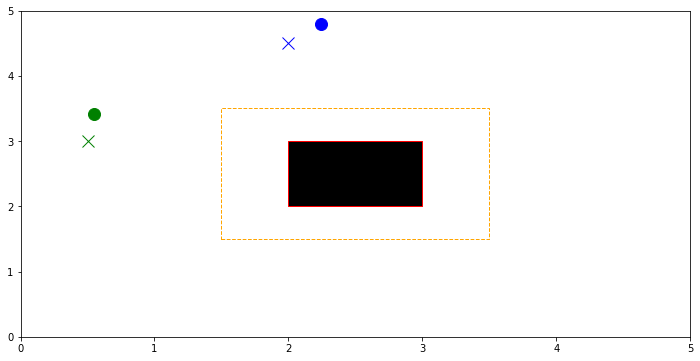

100%|███████████████████████████████████████████| 54/54 [00:19<00:00,  2.81it/s]


In [17]:
time.sleep(1.25)


for t in tqdm(np.arange(0, rrtdb.total_time + rrtdb.dt, rrtdb.dt)):
    time.sleep(0.25)
    clear_output(wait=True)
    print(f"Bot's velocity: {rrtdb.plan.get(t)} time: {rrtdb.plan.times[int(t//rrtdb.dt)]}")
    Frame(dbots=[rrtdb, rrtdb2], obstacles=rect_list, delta_obs = expanded_list, time = t, lb=lb, ub=ub).show_frame()

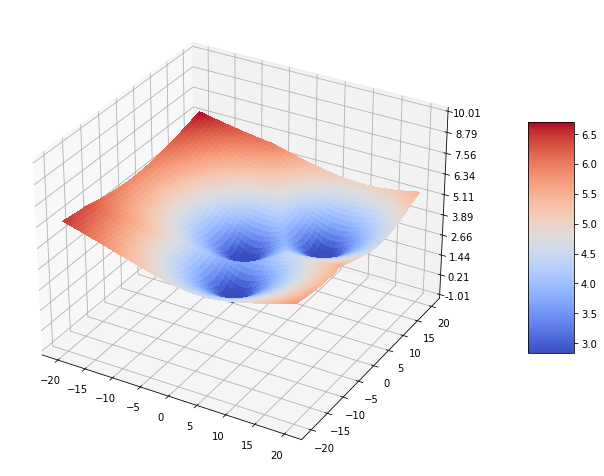

In [25]:
edges = [(0, 0), (10, 7), (4, -10)]
def circ(x_0, y_0):
    def f(x, y):
        s = 2**0.5
        return s + (((x - x_0) ** 2 + (y - y_0) ** 2) ** 0.5) ** 0.5
    return f

circle_constraints = [circ(x, y) for x, y in edges]

def f(x, y):

    A = np.min(np.array([circle(x, y) for circle in circle_constraints]), axis = 0)
    B = np.full_like(np.array(x), 2*np.sqrt(2))

    return np.where(A > B, A, B)

x = np.linspace(-20, 20, 2560)
y = np.linspace(-20, 20, 2560)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

fig = plt.figure()
plt.rcParams["figure.figsize"] = (21,8.5)

ax2 = plt.subplot(111, projection="3d")

# Plot the surface.
surf = ax2.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax2.set_zlim(-1.01, 10.01)
ax2.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax2.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, ax=ax2, shrink=0.5, aspect=5)

plt.savefig("test.png")
plt.show()